A partire da questo dataset, costruire una pipeline di feature engineering per poi supportare il training di un modello di regressione per il prezzo dell'auto nel mercato dell'usato. Evidenzia in maniera chiara l'effetto che ha la feature engineering nelle metriche di efficacia del modello.

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# ESPLORAZIONE DEI DATI

In [2]:
df = pd.read_csv('used_cars.csv')

In [3]:
# esploro i dati
# Controllo le prime righe del dataset
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [4]:
# Verifico la struttura del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [5]:
# Controllo se ci sono valori mancanti
df.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [6]:
# Visualizzostatistiche descrittive per le colonne numeriche
print(df.describe())

        model_year
count  4009.000000
mean   2015.515590
std       6.104816
min    1974.000000
25%    2012.000000
50%    2017.000000
75%    2020.000000
max    2024.000000


In [7]:
# Visualizzo le features
df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [8]:
# Conteggio dei valori unici presenti in ogni colonna del DataFrame
df.nunique()

brand             57
model           1898
model_year        34
milage          2818
fuel_type          7
engine          1146
transmission      62
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

In [9]:
# Creo una copia del DataFrame
df_copy = df.copy()

# Rimuovo il simbolo del dollaro e le virgole nella colonna 'price' della copia
df_copy['price'] = df_copy['price'].replace({'\$': '', ',': ''}, regex=True)

# Converto la colonna 'price' in numerico (int o float)
df_copy['price'] = pd.to_numeric(df_copy['price'])

# Rimuovo la virgola e la parte del testo 'mi.'
df_copy['milage'] = df_copy['milage'].replace({',': '', ' mi.': ''}, regex=True)

# Converto la colonna in numerico 
df_copy['milage'] = pd.to_numeric(df_copy['milage'])

# Converto la colonna in int
df_copy['milage'] = df_copy['milage'].astype(int)


In [10]:
# Imposto il formato di visualizzazione per i numeri in pandas
pd.options.display.float_format = '{:,.0f}'.format

# visualizzo le caratteristiche descrittive delle nuove colonne numeriche
df_copy.describe()

,model_year,milage,price
count,"4,009","4,009","4,009"
mean,"2,016","64,718","44,553"
std,6,"52,297","78,711"
min,"1,974",100,"2,000"
25%,"2,012","23,044","17,200"
50%,"2,017","52,775","31,000"
75%,"2,020","94,100","49,990"
max,"2,024","405,000","2,954,083"


C:\Users\franc\AppData\Local\Temp\ipykernel_2740\2596081399.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='brand', data=df, palette='Set2')


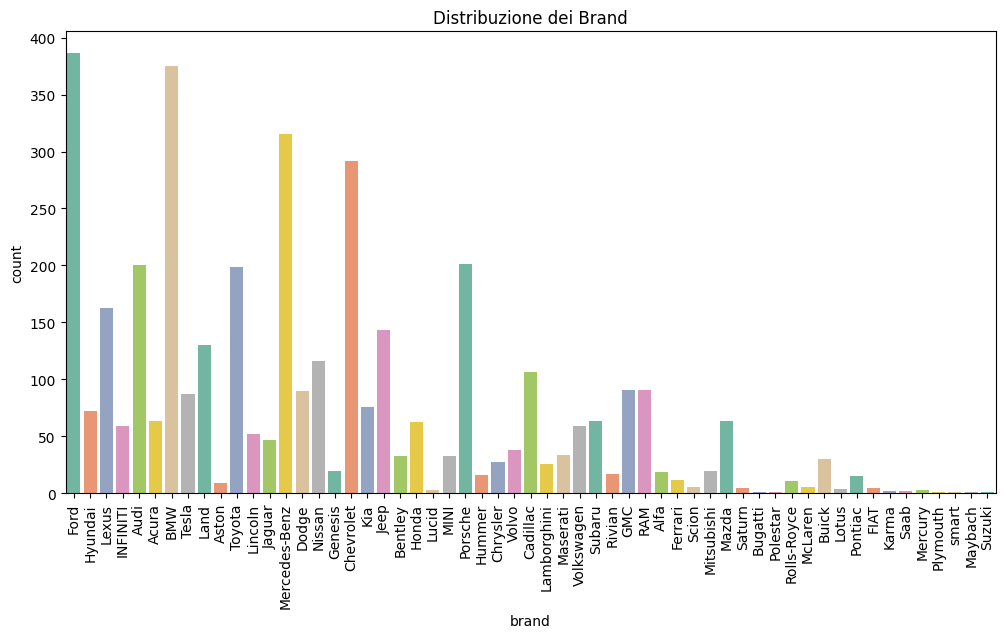

C:\Users\franc\AppData\Local\Temp\ipykernel_2740\2596081399.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fuel_type', data=df, palette='Set1')


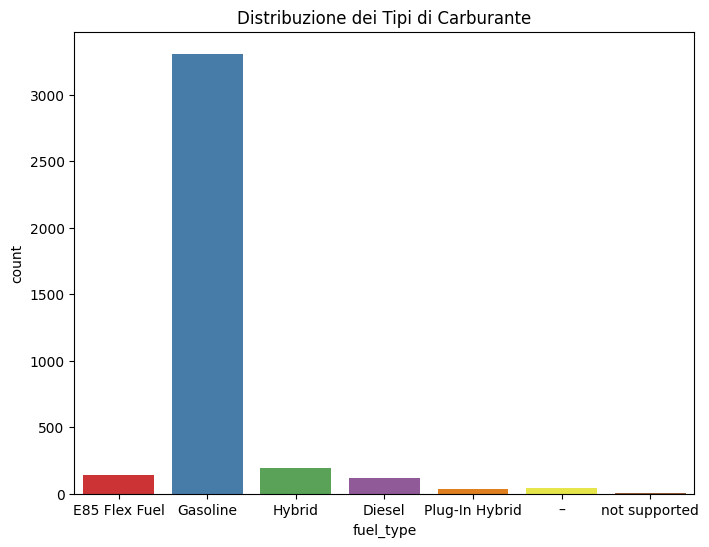

C:\Users\franc\AppData\Local\Temp\ipykernel_2740\2596081399.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='transmission', data=df, palette='Paired')


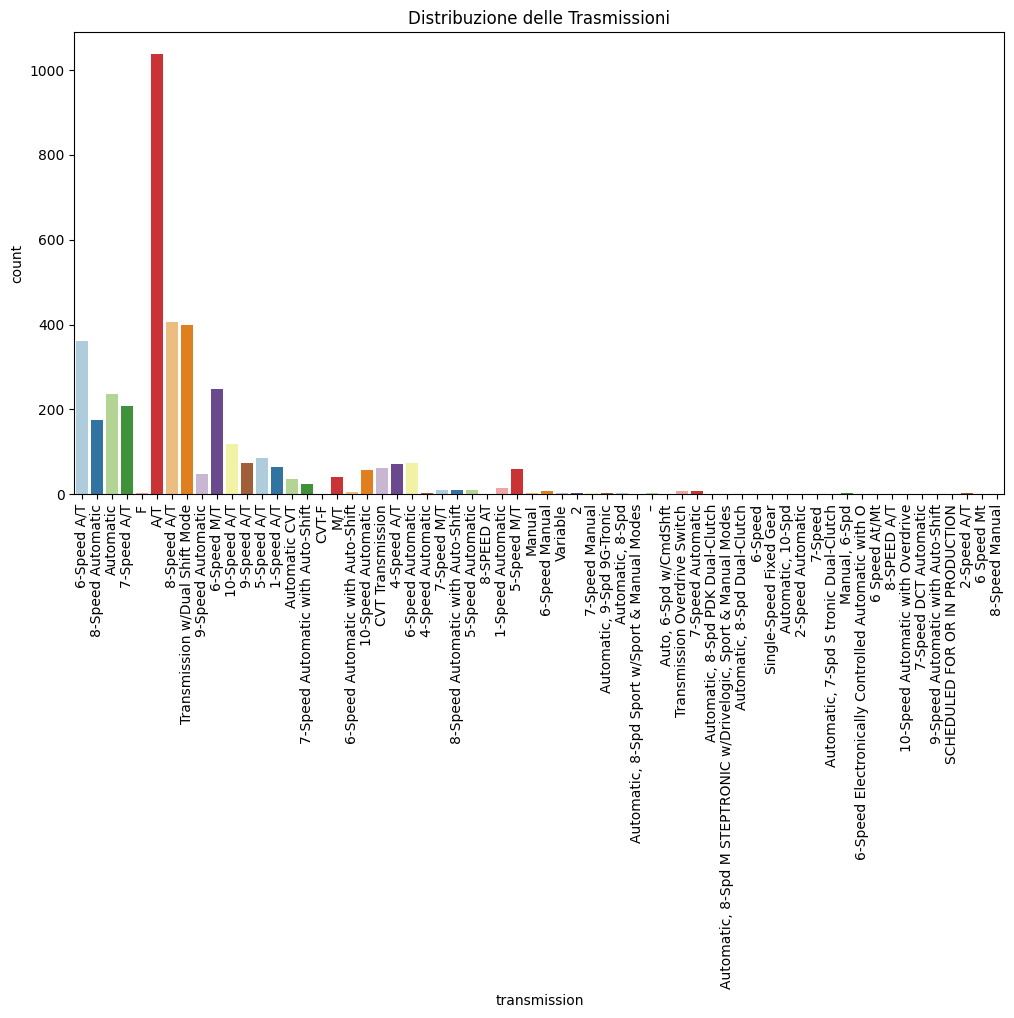

In [11]:
# creo grafici di distribuzione
# a. Distribuzione del Brand
plt.figure(figsize=(12, 6))
sns.countplot(x='brand', data=df, palette='Set2')
plt.title('Distribuzione dei Brand')
plt.xticks(rotation=90)
plt.show()

# b. Distribuzione del Tipo di Carburante
plt.figure(figsize=(8, 6))
sns.countplot(x='fuel_type', data=df, palette='Set1')
plt.title('Distribuzione dei Tipi di Carburante')
plt.show()

# c. Distribuzione della Trasmissione
plt.figure(figsize=(12, 6))
sns.countplot(x='transmission', data=df, palette='Paired')
plt.title('Distribuzione delle Trasmissioni')
plt.xticks(rotation=90)
plt.show()

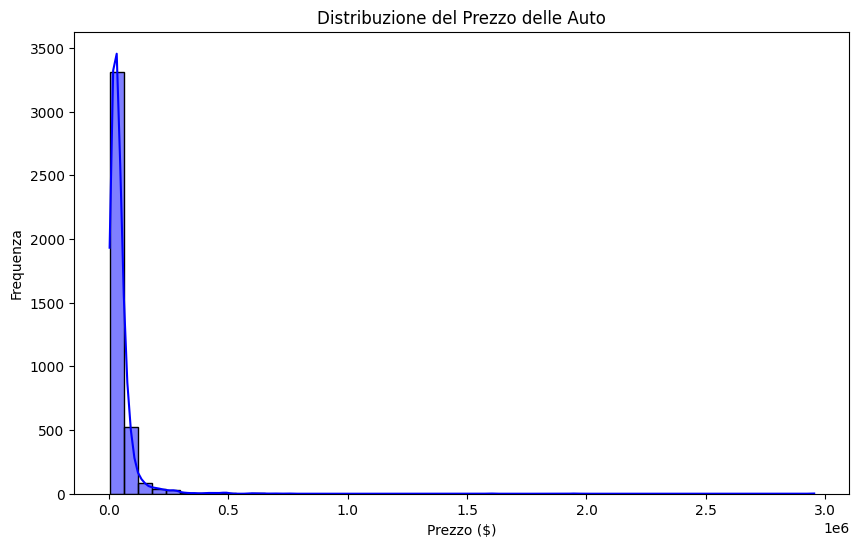

In [12]:
# 1. Distribuzione del Prezzo
plt.figure(figsize=(10, 6))
sns.histplot(df_copy['price'], bins=50, kde=True, color='blue')
plt.title('Distribuzione del Prezzo delle Auto')
plt.xlabel('Prezzo ($)')
plt.ylabel('Frequenza')
plt.show()

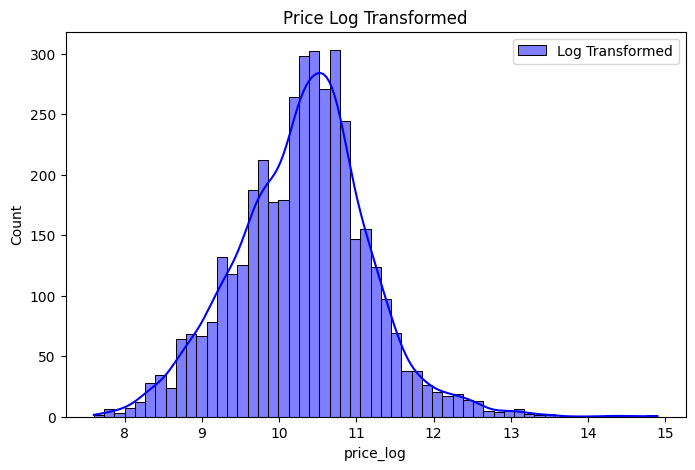

In [13]:
df_clean=df_copy.copy()
df_clean['price_log'] = np.log1p(df_clean['price'])

# Visualizzo la distribuzione del prezzo dopo aver applicato la trasformazione logaritmica
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['price_log'], kde=True, label='Log Transformed', color='blue')
plt.legend()
plt.title("Price Log Transformed")
plt.show()


C:\Users\franc\AppData\Local\Temp\ipykernel_2740\3672592772.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='model', data=df_filtered_model, palette='Set2')


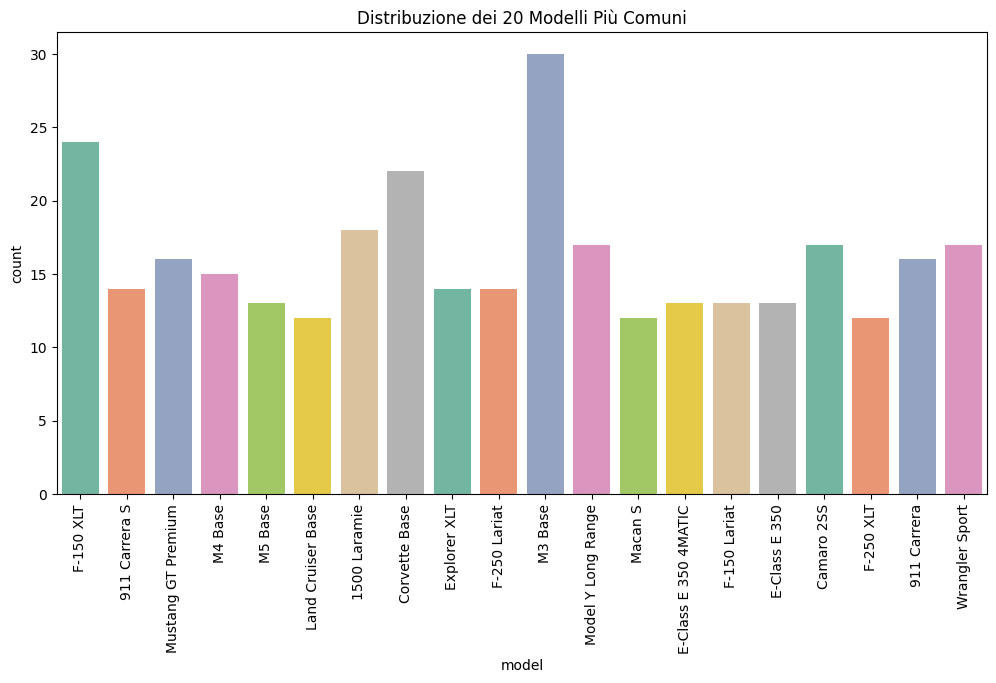

In [14]:
# Seleziono i 20 modelli più comuni
def filter_top_models(df, column, top_n=20):
    value_counts = df[column].value_counts()
    top_models = value_counts.head(top_n).index
    return df[df[column].isin(top_models)]

# Applico il filtro per 'model'
df_filtered_model = filter_top_models(df_copy, 'model', top_n=20)

# Visualizza la distribuzione dei 20 modelli più comuni
plt.figure(figsize=(12, 6))
sns.countplot(x='model', data=df_filtered_model, palette='Set2')
plt.title('Distribuzione dei 20 Modelli Più Comuni')
plt.xticks(rotation=90)
plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_2740\3951362679.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price', y='model', data=price_by_model, palette='viridis')


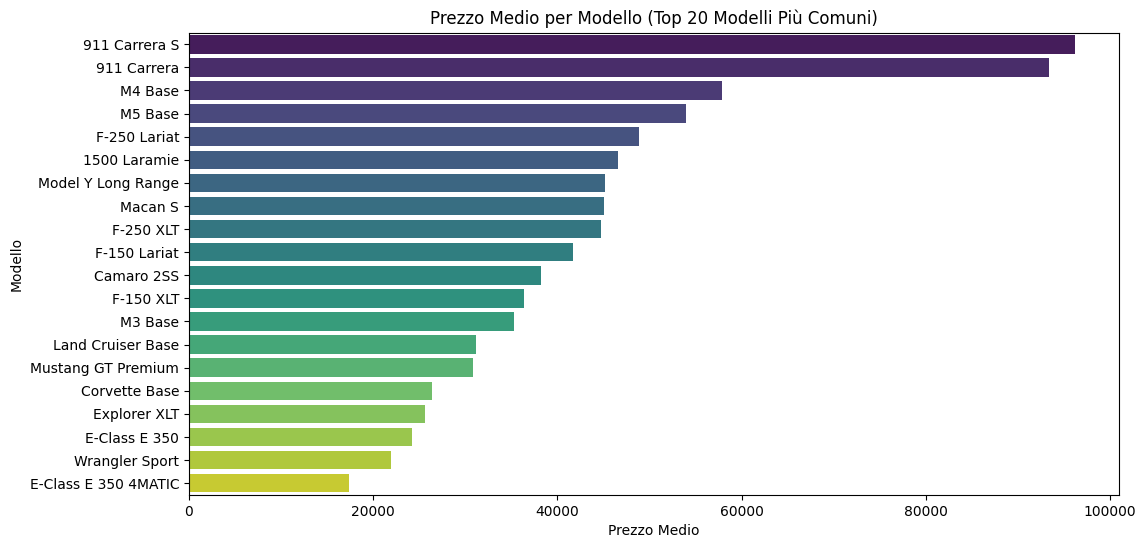

In [15]:
# Calcolo il prezzo medio per ciascun modello
price_by_model = df_filtered_model.groupby('model')['price'].mean().reset_index()

# Ordino per prezzo medio 
price_by_model = price_by_model.sort_values(by='price', ascending=False)

# Visualizzo il grafico
plt.figure(figsize=(12, 6))
sns.barplot(x='price', y='model', data=price_by_model, palette='viridis')
plt.title('Prezzo Medio per Modello (Top 20 Modelli Più Comuni)')
plt.xlabel('Prezzo Medio')
plt.ylabel('Modello')
plt.show()

In [16]:
# Tutte le colonne di tipo 'category' o 'object'
categorical_columns = df_copy.select_dtypes(include=['category', 'object']).columns.tolist()

# Visualizzare le colonne categoriche
print(categorical_columns)

['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [17]:
print(df_copy.dtypes)
df_copy = df_copy.dropna(subset=['price', 'milage'])

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object


Index(['model_year', 'milage', 'price'], dtype='object')


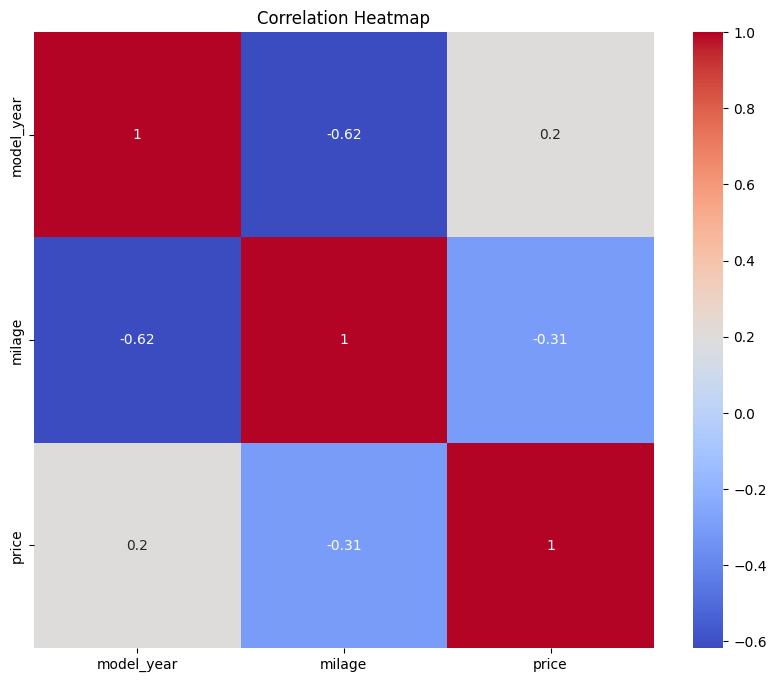

In [18]:
# SelezionO solo le colonne numeriche
numerical_features = df_copy.select_dtypes(include=['number']).columns

# VerificO le colonne numeriche
print(numerical_features)

# Correlation Analysis
correlation_matrix = df_copy[numerical_features].corr()  # Usa df_copy per evitare confusione tra df originali

# VisualizzO la heatmap di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# PRE PROCESSING DATI E APPLICAZIONE MODELLO

In [19]:
print(df_copy.dtypes)

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object


**1) APPLICO OneHotEncoder PER DATI CATEGORICI E StandardScaler PER VARIABILI NUMERICHE**

In [20]:
# DefiniscP le colonne categoriche e numeriche
categorical_columns = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
numerical_columns = ['model_year', 'milage']

# Creo un OneHotEncoder per tutte le colonne categoriche
encoder = OneHotEncoder(drop='first', sparse_output=False)  # sparse_output=True/False in place of sparse

# Applico One-Hot Encoding su tutte le colonne categoriche
X_cat = encoder.fit_transform(df_copy[categorical_columns])

# Converto la matrice in un DataFrame con i nomi delle colonne
encoded_columns = encoder.get_feature_names_out(categorical_columns)  # Nomi delle colonne codificate
X_cat_df = pd.DataFrame(X_cat, columns=encoded_columns)

# Rimuovo le colonne categoriche originali e le unisco con le variabili numeriche
X = df_copy.drop(columns=categorical_columns)
X = pd.concat([X, X_cat_df], axis=1)

# Separo la variabile target (price)
y = df_copy['price']

# Suddivido il dataset in training e test set (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizzazione delle variabili numeriche
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Creo il modello Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Previsioni sui dati di test
y_pred = model.predict(X_test)

# Valuto il modello
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.4f}')
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 5861.43
Mean Squared Error: 9726377204.89
R² Score: 0.5241
Mean Absolute Error: 5861.431309226931


Il modello sembra avere una performance moderata. Con un R² di circa 0.52, è in grado di spiegare più della metà della varianza, ma c'è ancora margine di miglioramento.
L'alto MSE suggerisce che ci sono errori significativi nelle previsioni, quindi potrebbero esserci dei problemi con la qualità delle stime o con la complessità del modello.
L'errore medio (MAE) di 5861 è relativamente elevato, il che potrebbe indicare che il modello non è abbastanza preciso per applicazioni che richiedono una previsione più fine.

**2) Ora applico la trasformazione logaritmica al price e la standardscaler alle altre due variabili numeriche**

In [21]:


# Definisco le colonne categoriche e numeriche
categorical_columns = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
numerical_columns = ['model_year', 'milage']

# Creo un OneHotEncoder per tutte le colonne categoriche
encoder = OneHotEncoder(drop='first', sparse_output=False)  # sparse_output=True/False in place of sparse

# Applico One-Hot Encoding su tutte le colonne categoriche
X_cat0 = encoder.fit_transform(df_clean[categorical_columns])

# Converto la matrice in un DataFrame con i nomi delle colonne
encoded_columns = encoder.get_feature_names_out(categorical_columns)  # Nomi delle colonne codificate
X_cat_df0 = pd.DataFrame(X_cat0, columns=encoded_columns)

# Rimuovo le colonne categoriche originali e le unisco con le variabili numeriche
X0= df_clean.drop(columns=categorical_columns)
X0 = pd.concat([X0, X_cat_df0], axis=1)

# Separo la variabile target (price)
y0 = df_clean['price_log']

# Suddivido il dataset in training e test set (80% training, 20% test)
X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=0.2, random_state=42)

# Standardizzazione delle variabili numeriche
scaler = StandardScaler()
X_train0[numerical_columns] = scaler.fit_transform(X_train0[numerical_columns])
X_test0[numerical_columns] = scaler.transform(X_test0[numerical_columns])

# Creo il modello Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train0, y_train0)

# Previsioni sui dati di test
y_pred0 = model.predict(X_test0)

# Valuto il modello
mae0 = mean_absolute_error(y_test0, y_pred0)
mse0 = mean_squared_error(y_test0, y_pred0)
r2_0 = r2_score(y_test0, y_pred0)

print(f'Mean Absolute Error: {mae0:.2f}')
print(f'Mean Squared Error: {mse0:.2f}')
print(f'R² Score: {r2_0:.4f}')
print(f"Mean Absolute Error: {mae0}")

Mean Absolute Error: 0.01
Mean Squared Error: 0.01
R² Score: 0.9933
Mean Absolute Error: 0.00557476969019852


Ottengo una Perfetta Adattabilità al Training Set: Questi risultati indicano che il modello ha una performance eccellente e si adatta molto bene ai dati di test. L'errore è praticamente nullo, il che è un segno che il modello sta facendo un ottimo lavoro nel predire i valori.

**3) Qui ho applicato la trasformazione logaritmica anche alle altre due variabili numeriche**

In [22]:
# Definisco le colonne categoriche e numeriche
categorical_columns = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
numerical_columns = ['model_year', 'milage']

# Creo un OneHotEncoder per tutte le colonne categoriche
encoder = OneHotEncoder(drop='first', sparse_output=False)  # sparse_output=True/False in place of sparse

# Applico One-Hot Encoding su tutte le colonne categoriche
X_cat1 = encoder.fit_transform(df_clean[categorical_columns])

# Converto la matrice in un DataFrame con i nomi delle colonne
encoded_columns = encoder.get_feature_names_out(categorical_columns)  # Nomi delle colonne codificate
X_cat_df1 = pd.DataFrame(X_cat1, columns=encoded_columns)

# Rimuovo le colonne categoriche originali e le unisco con le variabili numeriche
X1 = df_clean.drop(columns=categorical_columns)
X1 = pd.concat([X1, X_cat_df1], axis=1)

# Separo la variabile target (price_log)
y1 = df_clean['price_log']

# Suddivido il dataset in training e test set (80% training, 20% test)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Applico la trasformazione logaritmica alle variabili numeriche
X_train1[numerical_columns] = np.log1p(X_train1[numerical_columns])
X_test1[numerical_columns] = np.log1p(X_test1[numerical_columns])

# Creo il modello Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train1, y_train1)

# Previsioni sui dati di test
y_pred1 = model.predict(X_test1)

# Valutoil modello
mae1 = mean_absolute_error(y_test1, y_pred1)
mse1 = mean_squared_error(y_test1, y_pred1)
r2_1 = r2_score(y_test1, y_pred1)

# Stampo i risultati
print(f'Mean Absolute Error: {mae1:.2f}')
print(f'Mean Squared Error: {mse1:.2f}')
print(f'R² Score: {r2_1:.4f}')


Mean Absolute Error: 0.01
Mean Squared Error: 0.01
R² Score: 0.9933


Anche qui Il modello sta facendo previsioni con errore minimo sia in termini di errore assoluto che di errore quadratico medio.
La capacità del modello di spiegare la variabilità nei dati è straordinariamente alta (99.33% di varianza spiegata), il che è un risultato molto positivo.
L'uso della trasformazione logaritmica per la variabile target sembra essere stato un buon approccio per ridurre gli effetti di distribuzioni asimmetriche o outliers, migliorando così la previsione.

**4) Ho modificato un po' per prevenire overfitting di R2**

In [23]:
# Definisco le colonne categoriche e numeriche
categorical_columns = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
numerical_columns = ['model_year', 'milage']

# Creo un OneHotEncoder per tutte le colonne categoriche
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Applico One-Hot Encoding su tutte le colonne categoriche
X_cat2 = encoder.fit_transform(df_clean[categorical_columns])

# Converto la matrice in un DataFrame con i nomi delle colonne
encoded_columns = encoder.get_feature_names_out(categorical_columns)
X_cat_df2 = pd.DataFrame(X_cat2, columns=encoded_columns)

# Rimuovo le colonne categoriche originali e le unisco con le variabili numeriche
X2 = df_clean.drop(columns=categorical_columns)
X2 = pd.concat([X2, X_cat_df2], axis=1)

# Separo la variabile target (price_log)
y2 = df_clean['price_log']

# Suddivido il dataset in training e test set (80% training, 20% test)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Applico la trasformazione logaritmica alle variabili numeriche
X_train2[numerical_columns] = np.log1p(X_train2[numerical_columns])
X_test2[numerical_columns] = np.log1p(X_test2[numerical_columns])

# Creo del modello Random Forest con modifiche per prevenire overfitting
model = RandomForestRegressor(
    n_estimators=100,          # Numero di alberi
    max_depth=10,              # Limito la profondità degli alberi per evitare che diventino troppo complessi
    min_samples_split=10,      # Aumento il numero minimo di campioni per una divisione
    min_samples_leaf=5,        # Aumento il numero minimo di campioni in una foglia
    max_features='sqrt',      # Considero solo una frazione delle features per ogni split
    random_state=42           # Imposto la random seed per la riproducibilità
)

# Addestramento del modello
model.fit(X_train2, y_train2)

# Previsioni sui dati di test
y_pred2 = model.predict(X_test2)

# Valuto il modello
mae2 = mean_absolute_error(y_test2, y_pred2)
mse2 = mean_squared_error(y_test2, y_pred2)
r2_2 = r2_score(y_test2, y_pred2)

# Stampo i risultati
print(f'Mean Absolute Error: {mae2:.2f}')
print(f'Mean Squared Error: {mse2:.2f}')
print(f'R² Score: {r2_2:.4f}')


Mean Absolute Error: 0.45
Mean Squared Error: 0.44
R² Score: 0.4309


ottengo dei risultati peggiori

In [24]:
def wmape(y_true, y_pred, weights=None):
    """Calcola il Weighted Mean Absolute Percentage Error (WMAPE).
    
    Parametri:
    y_true (array-like): Valori reali
    y_pred (array-like): Valori previsti
    weights (array-like, opzionale): Pesi per ogni osservazione
    
    Restituisce:
    float: valore del WMAPE
    """
    if weights is None:
        weights = np.ones_like(y_true)
    
    # Evita la divisione per zero
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0  # Ignora le osservazioni con valore 0
    
    return np.sum(weights[mask] * np.abs(y_true[mask] - y_pred[mask])) / np.sum(weights[mask] * np.abs(y_true[mask]))


In [25]:
# Applica WMAPE
# Puoi usare i pesi personalizzati, ad esempio pesi che enfatizzano le osservazioni più recenti
wmape_value = wmape(y_test1, y_pred1)
print(f'Weighted Mean Absolute Percentage Error (WMAPE): {wmape_value:.4f}')

Weighted Mean Absolute Percentage Error (WMAPE): 0.0005


Ho applicato WMAPE che  misura l'errore medio percentuale tra i valori predetti dal modello e quelli reali. Ho ottenuto un valore molto  basso che implica che il modello sta facendo un lavoro eccellente nel prevedere i prezzi delle auto usate. Le previsioni sono molto vicine ai valori reali, il che significa che il modello ha una buona capacità di generalizzazione e non sta commettendo errori significativi.
Per il calcolo ho utilizzato il **terzo** modello 